## Imports

#### Import packages, set options for displaying and for generating reproducable results (random seed)

In [2]:
%matplotlib inline
import xgboost
import sklearn
import matplotlib
import matplotlib.pyplot as plt 

import numpy as np
import pandas as pd
import time
from collections import Counter
from IPython.display import display, HTML

from sklearn.preprocessing import Imputer
from sklearn.externals import joblib
from sklearn.cross_validation import train_test_split, StratifiedKFold, cross_val_score
from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier,RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score,log_loss, accuracy_score, make_scorer
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 500)
np.set_printoptions(precision=3)
#seed = 1234
seed = None


print("Numpy:",np.__version__)
print("Pandas:",pd.__version__)
print("XGBoost:",xgboost.__version__)
print("sklearn:",sklearn.__version__)
print("matplotlib:",matplotlib.__version__)

Numpy: 1.13.3
Pandas: 0.22.0
XGBoost: 0.7.post3
sklearn: 0.19.1
matplotlib: 1.5.1


/opt/conda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Load dataset

In [27]:
#input_file = "/notebooks/data/ait_result_dataset.V37.csv"
input_file = "/notebooks/aftdbcsv/aftdb.csv"


df = pd.read_csv(input_file, header = 0)

#y=df['target'].as_matrix()

ref=pd.read_csv('reference_aftdb.txt',header=None)
#ref=pd.read_csv('REFERENCE-v2.csv',header=None)
#ref=pd.read_csv('REFERENCE.csv',header=None)
#ref=pd.read_csv('REFERENCE_TEIJEIRO.csv',header=None)
#ref=pd.read_csv('REFERENCE_custom.csv',header=None)

ref=ref[1].as_matrix()

y=ref
display(y)
print("y: "+str(y.shape))


classes= ['A', 'N', 'O','~']

print(classes)
#df=df.drop('target',axis=1)
print("DF: "+str(df.shape))
df=df.dropna(axis=1, how='all')
print("DF after dropna: "+str(df.shape))

#drop "combined" columns
#filter_col = [col for col in df if col.startswith('combined')]
#display(filter_col)
#df=df.drop(filter_col,axis=1)
#print("df: "+str(df.shape))

X=df.as_matrix()
print("X: "+str(X.shape))
imp = Imputer(missing_values='NaN', strategy='mean', axis=0,verbose=1)
X=imp.fit_transform(X)
print("X after imputer:"+str(X.shape))

array(['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A'], dtype=object)

y: (160,)
['A', 'N', 'O', '~']
DF: (160, 386)
DF after dropna: (160, 386)
X: (160, 386)
X after imputer:(160, 386)


## Define test metrics

In [28]:
cv = StratifiedKFold(y, n_folds=5, shuffle=True, random_state=seed)

def my_custom_f1(y_true, predictions):
    f1_classes=f1_score(y_true, predictions, labels=classes, average=None)
    f1_classes_cv.append(f1_classes)
    f1_custom=f1_score(y_true, predictions, labels=['Yes','No'], average='macro')
    print("F1 scores: ",f1_classes)
    print("F1 mean: {0:.3f}".format(f1_custom))
    return f1_custom

global f1_classes_cv

def test_classifier(clf,X,y):
    predictions = clf.predict(X)

    print("F1: {:1.4f}".format(f1_score(y, predictions,labels=classes,average='macro')))  

    #display(pd.DataFrame(xgb_y_pred))
    correct = 0

    for i in range(len(predictions)):
        if (y[i] == predictions[i]):
            correct += 1
    acc = accuracy_score(y, predictions)
    print('Predicted correctly: {0}/{1}'.format(correct, len(predictions)))
    print('Error: {0:.4f}'.format(1-acc))
    #scorer = make_scorer(f1_score, labels=['A','O','N'], average='macro')
    global f1_classes_cv
    f1_classes_cv=[]
    scorer = make_scorer(my_custom_f1)
    scores = cross_val_score(clf, X, y, cv=cv,scoring=scorer)
    print(f1_classes_cv)
    f1_classes_cv=np.vstack(f1_classes_cv)
    f1_classes_cv=np.mean(f1_classes_cv,axis=0)

    print("== 5-fold CV ==")
    print("F1 scores 5-fold CV per iteration:",scores)
    print("F1 mean 5-fold CV per class:",f1_classes_cv)
    print("F1 mean 5-fold CV: {0:.3f}".format(np.mean(scores)))
    return np.mean(scores),f1_classes_cv


class Timer(object):
    def __init__(self, name=None):
        self.name = name

    def __enter__(self):
        self.tstart = time.time()

    def __exit__(self, type, value, traceback):
        if self.name:
            print('[%s]' % self.name)
        print('Elapsed: %.1f' % (time.time() - self.tstart))

## XGBoost

### Load XGB model trained on CinC db

In [39]:
bst=joblib.load('xgboost_joblib.pkl')
rf=joblib.load('rf_joblib.pkl')

### Test

In [41]:
predictions=bst.predict(X)
correct = 0
display(y)
print(pd.DataFrame(predictions).describe())
#test_classifier(bst,X,y)
for i in range(len(predictions)):
    if (y[i] == predictions[i]):
        correct += 1
acc = accuracy_score(y, predictions)
print('Predicted correctly: {0}/{1}'.format(correct, len(predictions)))
print('Error: {0:.4f}'.format(1-acc))

print(pd.Series(predictions).value_counts())

array(['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A'], dtype=object)

          0
count   160
unique    4
top       A
freq    149
Predicted correctly: 149/160
Error: 0.0687
A    149
O      6
~      4
N      1
dtype: int64


## Random Forest

### Train

In [15]:
with Timer('Train RF'):
    rf = RandomForestClassifier(n_jobs=-1, random_state=seed,n_estimators=1000).fit(X, y)
    joblib.dump(rf,'rf_joblib.pkl', compress = 1)

[Train RF]
Elapsed: 30.7


### Test

In [16]:
with Timer('Test RF'):
    test_classifier(rf, X,y)

F1: 1.0000
Predicted correctly: 8528/8528
Error: 0.0000
F1 scores:  [ 0.845  0.897  0.745  0.627]
F1 mean: 0.829
F1 scores:  [ 0.807  0.898  0.738  0.578]
F1 mean: 0.814
F1 scores:  [ 0.834  0.915  0.765  0.71 ]
F1 mean: 0.838
F1 scores:  [ 0.804  0.917  0.775  0.685]
F1 mean: 0.832
F1 scores:  [ 0.844  0.911  0.787  0.583]
F1 mean: 0.847
[array([ 0.845,  0.897,  0.745,  0.627]), array([ 0.807,  0.898,  0.738,  0.578]), array([ 0.834,  0.915,  0.765,  0.71 ]), array([ 0.804,  0.917,  0.775,  0.685]), array([ 0.844,  0.911,  0.787,  0.583])]
== 5-fold CV ==
F1 scores 5-fold CV per iteration: [ 0.829  0.814  0.838  0.832  0.847]
F1 mean 5-fold CV per class: [ 0.827  0.908  0.762  0.637]
F1 mean 5-fold CV: 0.832
[Test RF]
Elapsed: 143.1


## Feature importance table

In [7]:
def fi_table(clf,df):
    fi=pd.DataFrame(clf.feature_importances_)
    fi.columns = ['Importance']
    cols=pd.DataFrame(list(df.columns))
    cols.columns = ['Feature']
    result = pd.concat( [fi, cols], axis=1)
    fi_sorted=result.sort_values(by='Importance', ascending=False)
    return fi_sorted

fi_sorted=fi_table(bst,df)

print(fi_sorted)

     Importance                                            Feature
381    0.012885                         combined_normalOrOther_new
67     0.010289                                  beat_bci_skewness
65     0.009548                                  beat_amp_skewness
265    0.008806                                  af_mean_atrialHR1
61     0.008250                                     qrs_drift_mean
6      0.008157                             commonPattern_amp_gini
382    0.008065                            combined_normalOrAF_new
33     0.007972                                      P_corr_median
383    0.007879                         combined_normalOrNoise_new
15     0.007879                              commonPattern_BCI_max
9      0.007786                           commonPattern_width_mean
307    0.007601                                         av_T_amp_1
24     0.007416                                         P_corr_max
275    0.007323                                   af_mean_atri

## Test top n features

In [ ]:
idx_range=np.arange(1,387,1)
#idx_range=[35]
#idx_range=[1,50,100,150,200,250,300,350,386]
print(idx_range)

f1=[]
f1_class_scores=[]
for idx in idx_range:
    ind=fi_sorted.tail(n=386-idx)
    ind=ind.iloc[:,-1]
    df_reduced=df.drop(ind,axis=1)
    X_reduced=df_reduced.as_matrix()
    imp = Imputer(missing_values='NaN', strategy='mean', axis=0,verbose=1)
    X_reduced=imp.fit_transform(X_reduced)
    print(X_reduced.shape)
    #clf_reduced = XGBClassifier(**params).fit(X_reduced, y,verbose=50)
    clf_reduced = RandomForestClassifier(n_jobs=-1, random_state=seed,n_estimators=1000).fit(X_reduced, y)
    f1_loop, f1_class_scores_loop=test_classifier(clf_reduced,X_reduced,y)
    f1.append(f1_loop)
    f1_class_scores.append(f1_class_scores_loop)

#joblib.dump(f1, 'f1_rf.pkl', compress = 1)
#joblib.dump(f1_class_scores, 'f1_class_scores_rf.pkl', compress = 1)

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 24

## Plot: Number of features - F1 score

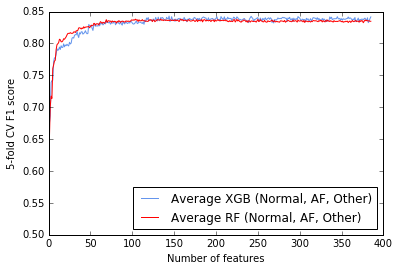

== XGBoost ==
50 XGB Mean 0.828
50 XGB Normal 0.903
50 XGB AF 0.824
50 XGB Other 0.757
50 XGB Noise 0.636
== RandomForest ==
50 RF Mean 0.825
50 RF Normal 0.903
50 RF AF 0.819
50 RF Other 0.752
50 RF Noise 0.615


In [51]:
#XGBoost
import matplotlib.pyplot as plt

f1=joblib.load('f1.pkl')
f1_class_scores=joblib.load('f1_class_scores.pkl')
f1_other=[]
f1_normal=[]
f1_af=[]
f1_noise=[]
for i in range(1,len(f1_class_scores)):
    f1_normal.append(f1_class_scores[i][1])
    f1_other.append(f1_class_scores[i][2])
    f1_af.append(f1_class_scores[i][0])
    f1_noise.append(f1_class_scores[i][3])
    
color = 'cornflowerblue'

plt.plot(f1, color=color,label='Average XGB (Normal, AF, Other)')
#plt.plot(f1_normal, label='Normal')
#plt.plot(f1_af, label='AF')
#plt.plot(f1_other, label='Other')
#plt.plot(f1_noise, label='Noise')
plt.legend(loc='lower right')
plt.ylabel('5-fold CV F1 score')
plt.xlabel('Number of features')

#RandomForest
f1_rf=joblib.load('f1_rf.pkl')
f1_class_scores_rf=joblib.load('f1_class_scores_rf.pkl')
f1_other_rf=[]
f1_normal_rf=[]
f1_af_rf=[]
f1_noise_rf=[]

for i in range(1,len(f1_class_scores_rf)):
    f1_normal_rf.append(f1_class_scores_rf[i][1])
    f1_other_rf.append(f1_class_scores_rf[i][2])
    f1_af_rf.append(f1_class_scores_rf[i][0])
    f1_noise_rf.append(f1_class_scores_rf[i][3])
    
color = 'red'
plt.plot(f1_rf, color=color,label='Average RF (Normal, AF, Other)')
#plt.plot(f1_normal, label='Normal')
#plt.plot(f1_af, label='AF')
#plt.plot(f1_other, label='Other')
#plt.plot(f1_noise, label='Noise')
plt.legend(loc='lower right')
plt.ylabel('5-fold CV F1 score')
plt.xlabel('Number of features')

plt.savefig('n_feat-f1.png',dpi=300)
plt.show()

N_FEATURES=50
print("== XGBoost ==")
print(N_FEATURES,"XGB Mean {0:.3f}".format(f1[N_FEATURES-1]))
print(N_FEATURES,"XGB Normal {0:.3f}".format(f1_class_scores[N_FEATURES-1][1]))
print(N_FEATURES,"XGB AF {0:.3f}".format(f1_class_scores[N_FEATURES-1][0]))
print(N_FEATURES,"XGB Other {0:.3f}".format(f1_class_scores[N_FEATURES-1][2]))
print(N_FEATURES,"XGB Noise {0:.3f}".format(f1_class_scores[N_FEATURES-1][3]))
print("== RandomForest ==")
print(N_FEATURES,"RF Mean {0:.3f}".format(f1_rf[N_FEATURES-1]))
print(N_FEATURES,"RF Normal {0:.3f}".format(f1_class_scores_rf[N_FEATURES-1][1]))
print(N_FEATURES,"RF AF {0:.3f}".format(f1_class_scores_rf[N_FEATURES-1][0]))
print(N_FEATURES,"RF Other {0:.3f}".format(f1_class_scores_rf[N_FEATURES-1][2]))
print(N_FEATURES,"RF Noise {0:.3f}".format(f1_class_scores_rf[N_FEATURES-1][3]))




# Cross validated predictions of model

In [ ]:
from sklearn.model_selection import cross_val_predict
y_pred = cross_val_predict(bst, X, y,cv=cv)
df_y_pred=pd.DataFrame(y_pred)
df_y_pred.to_csv('df_y_pred_5xCV.txt')

# Neural Network: Train and test

In [193]:
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier(alpha=0.01, random_state=seed)


nn=nn.fit(X, y)    
print(nn)
test_classifier(nn,X,y)


MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
F1: 0.7732
Predicted correctly: 6947/8528
Error: 0.1854
F1 scores:  [ 0.721  0.897  0.686  0.542]
F1 mean: 0.768
F1 scores:  [ 0.77   0.873  0.693  0.614]
F1 mean: 0.778
F1 scores:  [ 0.556  0.88   0.624  0.466]
F1 mean: 0.686
F1 scores:  [ 0.781  0.817  0.659  0.535]
F1 mean: 0.752
F1 scores:  [ 0.757  0.883  0.679  0.617]
F1 mean: 0.773
[array([ 0.721,  0.897,  0.686,  0.542]), array([ 0.77 ,  0.873,  0.693,  0.614]), array([ 0.556,  0.88 ,  0.624,  0.466]), array([ 0.781,  0.817,  0.659,  0.535]), array([ 0.757,  0.883,  0.679,  0.617])]
== 5-fold CV ==
F1 sc

(0.75164421863039366, array([ 0.717,  0.87 ,  0.668,  0.555]))

# Test for statiscal difference on N runs with random seed

In [41]:
N=25

f1_xgb=[]
f1_class_scores_xgb=[]
f1_rf=[]
f1_class_scores_rf=[]
print("Seed",seed)
for i in range(1,N):
    print('Iteration',i)
    cv = StratifiedKFold(y, n_folds=5, shuffle=True, random_state=seed)
    
    with Timer('Train RF'):
        rf = RandomForestClassifier(n_jobs=-1, random_state=seed,n_estimators=1000).fit(X, y)
    with Timer('Test RF'):
        f1_loop,f1_class_loop=test_classifier(rf,X,y)
        f1_rf.append(f1_loop)
        f1_class_scores_rf.append(f1_class_loop)       
    with Timer('Train XGB'):
        bst = XGBClassifier(**params).fit(X, y,verbose=50)
    with Timer('Test XGB'):
        f1_loop,f1_class_loop=test_classifier(bst,X,y)
        f1_xgb.append(f1_loop)
        f1_class_scores_xgb.append(f1_class_loop)       
        
    joblib.dump(f1_xgb, 'f1_xgb.pkl', compress = 1)
    joblib.dump(f1_class_scores_xgb, 'f1_class_scores_xgb.pkl', compress = 1)
    joblib.dump(f1_rf, 'f1_rf.pkl', compress = 1)
    joblib.dump(f1_class_scores_rf, 'f1_class_scores_rf.pkl', compress = 1)

Seed None
Iteration 1
[Train RF]
Elapsed: 30.1
F1: 1.0000
Predicted correctly: 8528/8528
Error: 0.0000
F1 scores:  [ 0.839  0.914  0.778  0.769]
F1 mean: 0.843
F1 scores:  [ 0.81   0.911  0.765  0.639]
F1 mean: 0.828
F1 scores:  [ 0.846  0.908  0.767  0.611]
F1 mean: 0.841
F1 scores:  [ 0.819  0.903  0.757  0.562]
F1 mean: 0.826
F1 scores:  [ 0.849  0.909  0.759  0.626]
F1 mean: 0.839
[array([ 0.839,  0.914,  0.778,  0.769]), array([ 0.81 ,  0.911,  0.765,  0.639]), array([ 0.846,  0.908,  0.767,  0.611]), array([ 0.819,  0.903,  0.757,  0.562]), array([ 0.849,  0.909,  0.759,  0.626])]
== 5-fold CV ==
F1 scores 5-fold CV per iteration: [ 0.843  0.828  0.841  0.826  0.839]
F1 mean 5-fold CV per class: [ 0.832  0.909  0.765  0.642]
F1 mean 5-fold CV: 0.836
[Test RF]
Elapsed: 140.7
[Train XGB]
Elapsed: 26.1
F1: 1.0000
Predicted correctly: 8528/8528
Error: 0.0000
F1 scores:  [ 0.851  0.915  0.79   0.724]
F1 mean: 0.852
F1 scores:  [ 0.805  0.915  0.764  0.673]
F1 mean: 0.828
F1 scores:  [

XGB: 0.839 +/- 0.003, RF 0.834 +/- 0.002
p-Value: 0.0000000678
p-Value: 0.0000266915


/opt/conda/lib/python3.5/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


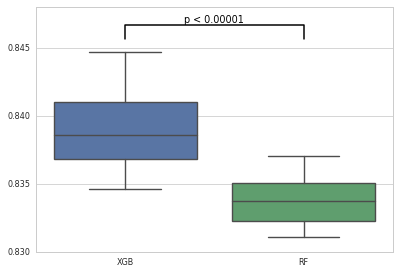

In [183]:
from scipy import stats
#np.random.seed(12345678)
print("XGB: %.3f +/- %.3f, RF %.3f +/- %.3f"%(np.mean(f1_xgb),np.std(f1_xgb),np.mean(f1_rf),np.std(f1_rf)))
statistic,p_value=stats.ttest_rel(f1_rf,f1_xgb)
print('p-Value: %.10f' % (float(p_value)))

statistic,p_value=stats.wilcoxon(f1_rf,f1_xgb)
print('p-Value: %.10f' % (float(p_value)))
                                
                                
df_f1_xgb=pd.DataFrame(f1_xgb)
df_f1_xgb.columns = ['XGB']
df_f1_rf=pd.DataFrame(f1_rf)
df_f1_rf.columns = ['RF']
df_f1=pd.concat([df_f1_xgb,df_f1_rf],axis=1)


#data_to_plot = [f1_xgb, f1_rf]
# Create a figure instance
#fig = plt.figure(1, figsize=(7, 5))

# Create an axes instance
#ax = fig.add_subplot(111)

# Create the boxplot
#bp = ax.boxplot(data_to_plot)

# Save the figure
#fig.savefig('fig1.png', bbox_inches='tight')


import seaborn as sns
sns.set_style("whitegrid")

sns.set_context("paper")

ax = sns.boxplot(data=df_f1)
x1, x2 = 0, 1 
y, h, col = df_f1['XGB'].max()+0.001, 0.0010, 'k'
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax.text((x1+x2)*.5, y+h, "p < 0.00001", ha='center', va='bottom', color=col)
fig = ax.get_figure()
fig.savefig('Boxplot.png', format='png', dpi=1200)
fig.savefig('Boxplot.svg', format='svg', dpi=1200)

In [114]:
df

,XGB,RF
0,0.834661,0.835536
1,0.835539,0.835410
2,0.838969,0.833437
3,0.842224,0.831137
4,0.836635,0.832121
5,0.840684,0.834115
6,0.839308,0.832223
7,0.842303,0.833058
8,0.844665,0.836833
9,0.842354,0.834949
